# Essay Analyzser

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it")

In [3]:
from langchain_ollama import ChatOllama

ollama_llm = ChatOllama(model="llama3.2:1b")

In [22]:
sample_essay = """
    The Impact of Artificial Intelligence on Modern Society

    Artificial Intelligence (AI) has become an integral part of our daily lives, 
    revolutionizing various sectors including healthcare, finance, and transportation. 
    This essay explores the profound effects of AI on modern society, discussing both 
    its benefits and potential challenges.

    One of the most significant impacts of AI is in the healthcare industry. 
    AI-powered diagnostic tools can analyze medical images with high accuracy, 
    often surpassing human capabilities. This leads to earlier detection of diseases 
    and more effective treatment plans. Moreover, AI algorithms can process vast 
    amounts of medical data to identify patterns and insights that might escape 
    human observation, potentially leading to breakthroughs in drug discovery and 
    personalized medicine.

    In the financial sector, AI has transformed the way transactions are processed 
    and monitored. Machine learning algorithms can detect fraudulent activities in 
    real-time, enhancing security for consumers and institutions alike. Robo-advisors 
    use AI to provide personalized investment advice, democratizing access to 
    financial planning services.

    The transportation industry is another area where AI is making significant strides. 
    Self-driving cars, powered by complex AI systems, promise to reduce accidents 
    caused by human error and provide mobility solutions for those unable to drive. 
    In logistics, AI optimizes routing and inventory management, leading to more 
    efficient supply chains and reduced environmental impact.

    However, the rapid advancement of AI also presents challenges. There are concerns 
    about job displacement as AI systems become capable of performing tasks 
    traditionally done by humans. This raises questions about the need for retraining 
    and reskilling the workforce to adapt to an AI-driven economy.

    Privacy and ethical concerns also arise with the increasing use of AI. The vast 
    amount of data required to train AI systems raises questions about data privacy 
    and consent. Additionally, there are ongoing debates about the potential biases 
    in AI algorithms and the need for transparent and accountable AI systems.

    In conclusion, while AI offers tremendous benefits and has the potential to solve 
    some of humanity's most pressing challenges, it also requires careful consideration 
    of its societal implications. As we continue to integrate AI into various aspects 
    of our lives, it is crucial to strike a balance between technological advancement 
    and ethical considerations, ensuring that the benefits of AI are distributed 
    equitably across society.
    """

In [23]:
from pydantic import BaseModel, Field

class State(BaseModel):
    essay: str = Field(..., description="The written essay to be analysed")
    relevance_score: float = Field(..., description="relevancy of total essay")
    grammer_score: float = Field(..., description="score for grammer correctness")
    structure_score: float = Field(..., description="score for proper structuring")
    depth_score: float = Field(..., description="score for depth coverage in the essay")
    final_score: float = Field(..., description="Final score for complete essay")

#Grading Functions

In [27]:
from langchain_core.prompts import ChatPromptTemplate

async def relevence_grading(essay): #(state:State)->State
    """Check the input essay for relevance and provides score between 0 and 1"""
    template = """
        You are an Essay analyzer. Analyse the relevance of following essay to given topic.
        Provide a relevence score between 0 and 1.
        Provide the relevency score in the form of float with keyword: 'Score'.
        Then provide your explanation.
        \n\nEssay: {essay}
        \n\nScore:
    """
    prompt = ChatPromptTemplate.from_template(template= template)

    chain = prompt | llm
    response = await chain.ainvoke({"essay": essay})
    relevance_score = response.content
    return relevance_score

In [28]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

asyncio.run(relevence_grading(sample_essay))

'Score: 1.0\n\nExplanation: \nThe essay directly and thoroughly addresses the topic "The Impact of Artificial Intelligence on Modern Society." It comprehensively explores both the positive aspects (healthcare, finance, transportation) and the potential challenges (job displacement, privacy concerns, ethical considerations) of AI. The essay provides specific examples and demonstrates a clear understanding of the multifaceted nature of AI\'s influence on modern society.  \n\n'

In [6]:
async def check_grammer(state:State)->State:
    """Checks grammar for mistakes and score the essay for grammar accordingly"""
    template = """
        Your a grammer analyzer. Your task is to analyse the grammer and language of the following essay.
        Provide score for grammer in between 0 to 1.
        Return the grammar score with keyword: 'grammer_score', as a  float.
        Then provide your Explanation.
        \n\nEssay: {essay}
        \n\nGrammer_score:
    """
    prompt = ChatPromptTemplate.from_template(template=template)

    grammer_chain = await ollama_llm.ainvoke({"essay": state.essay})
    state.grammer_score = grammer_chain.content
    return state

In [7]:
async def structure_grader(state: State)->State:
    """Analyses the structure and syntactic arrangement of the essay and provides score"""
    template = """
        Your an essay structure analyser. Youe task is to analyze the structure and syntactc arrangement of the followning essay and grading it.
        Grade the essay between 0 an 1.
        Retrun the response with keyword: 'structure_score', as a float value. 
        Then provide your explanation.
        \n\nEssay: {essay}
        \n\nStructure Score:
    """
    prompt = ChatPromptTemplate.from_template(template=template)

    structure_chain = prompt | ollama_llm
    result = await structure_chain.ainvoke({"essay": state.essay})
    state.structure_score = result.content
    return state

In [8]:
async def depth_evaluator(state:State)->State:
    """Analyses and grades the essay for its coverage and its depth"""
    template = """
        Your an essay depth analyser. Your task is to take following essay and analyse the depth and coverage of essay and grading it.
        Grade the essay depth between 0 to 1.
        Return the score with keyword: 'depth_score', as a float.
        Then provide your explanation.
        \n\nEssay: {essay}
        \n\nDepth Score:
    """
    prompt = ChatPromptTemplate.from_template(template=template)

    depth_eval_chain = prompt | ollama_llm
    result = await depth_eval_chain.ainvoke({"essay": state.essay})
    state.depth_score = result.content
    return state

In [9]:
def calculate_final_score(state: State)-> State:
    """Collects all the scores from state and calculate final score of essay"""
    state.final_score = (
        state.relevance_score * 0.3 +
        state.grammer_score * 0.2 +
        state.structure_score * 0.2 +
        state.depth_score * 0.3
    )
    return state

In [10]:
def router(state: State):
    """route the essay accordingly"""
    if state.relevance_score > 0.5:
        return "check_grammar"
    if state.grammer_score > 0.6:
        return "analyze_structure"
    if state.structure_score > 0.7:
        return "evaluate_depth"
    else:
        return "calculate_final_score"


#Workflow

In [11]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node("check_relevance", relevence_grading)
workflow.add_node("check_grammar", check_grammer)
workflow.add_node("analyze_structure", structure_grader)
workflow.add_node("evaluate_depth",  depth_evaluator)
workflow.add_node("calculate_final_score", calculate_final_score)

workflow.set_entry_point("check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    router,
    {
        "check_grammar" : "check_grammar",
        "analyze_structure" : "analyze_structure",
        "evaluate_depth" : "evaluate_depth"
    }
)
workflow.add_edge("evaluate_depth", "calculate_final_score")
workflow.add_edge("calculate_final_score", END)

graph = workflow.compile()

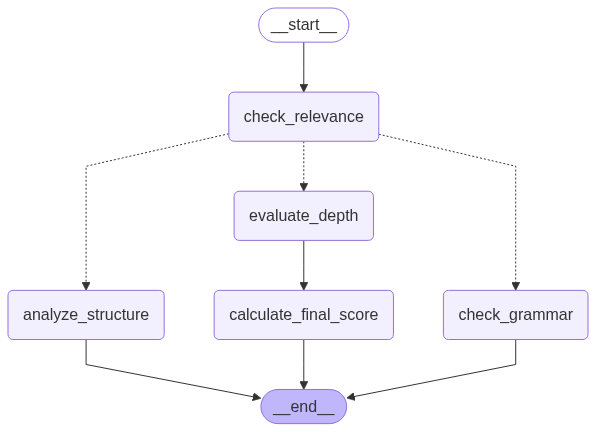

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
def grade_essay(essay: str) -> dict:
    """Grade the given essay using the defined workflow."""
    initial_state = State(
        essay=essay,
        relevance_score=0.0,
        grammar_score=0.0,
        structure_score=0.0,
        depth_score=0.0,
        final_score=0.0
    )
    result = graph.invoke(initial_state)
    return result

In [19]:
sample_essay = """
    The Impact of Artificial Intelligence on Modern Society

    Artificial Intelligence (AI) has become an integral part of our daily lives, 
    revolutionizing various sectors including healthcare, finance, and transportation. 
    This essay explores the profound effects of AI on modern society, discussing both 
    its benefits and potential challenges.

    One of the most significant impacts of AI is in the healthcare industry. 
    AI-powered diagnostic tools can analyze medical images with high accuracy, 
    often surpassing human capabilities. This leads to earlier detection of diseases 
    and more effective treatment plans. Moreover, AI algorithms can process vast 
    amounts of medical data to identify patterns and insights that might escape 
    human observation, potentially leading to breakthroughs in drug discovery and 
    personalized medicine.

    In the financial sector, AI has transformed the way transactions are processed 
    and monitored. Machine learning algorithms can detect fraudulent activities in 
    real-time, enhancing security for consumers and institutions alike. Robo-advisors 
    use AI to provide personalized investment advice, democratizing access to 
    financial planning services.

    The transportation industry is another area where AI is making significant strides. 
    Self-driving cars, powered by complex AI systems, promise to reduce accidents 
    caused by human error and provide mobility solutions for those unable to drive. 
    In logistics, AI optimizes routing and inventory management, leading to more 
    efficient supply chains and reduced environmental impact.

    However, the rapid advancement of AI also presents challenges. There are concerns 
    about job displacement as AI systems become capable of performing tasks 
    traditionally done by humans. This raises questions about the need for retraining 
    and reskilling the workforce to adapt to an AI-driven economy.

    Privacy and ethical concerns also arise with the increasing use of AI. The vast 
    amount of data required to train AI systems raises questions about data privacy 
    and consent. Additionally, there are ongoing debates about the potential biases 
    in AI algorithms and the need for transparent and accountable AI systems.

    In conclusion, while AI offers tremendous benefits and has the potential to solve 
    some of humanity's most pressing challenges, it also requires careful consideration 
    of its societal implications. As we continue to integrate AI into various aspects 
    of our lives, it is crucial to strike a balance between technological advancement 
    and ethical considerations, ensuring that the benefits of AI are distributed 
    equitably across society.
    """

In [21]:
# Grade the sample essay
result = grade_essay(sample_essay)

# Display the results
print(f"Final Essay Score: {result.final_score:.2f}\n")
print(f"Relevance Score: {result.relevance_score:.2f}")
print(f"Grammar Score: {result.grammar_score:.2f}")
print(f"Structure Score: {result.structure_score:.2f}")
print(f"Depth Score: {result.depth_score:.2f}")

ValidationError: 1 validation error for State
grammer_score
  Field required [type=missing, input_value={'essay': "\n    The Impa...0.0, 'final_score': 0.0}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing